Load Environment and Connection to DataBase

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load .env file
load_dotenv()

PGHOST     = os.getenv("PGHOST")
PGPORT     = os.getenv("PGPORT", "5432")
PGDATABASE = os.getenv("PGDATABASE")
PGUSER     = os.getenv("PGUSER")
PGPASSWORD = os.getenv("PGPASSWORD")
PGSSL      = os.getenv("PGSSL", "require")

assert PGHOST and PGDATABASE and PGUSER and PGPASSWORD, "❌ Missing DB env vars. Check your .env file!"

# Build SQLAlchemy engine
engine = create_engine(
    f"postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}?sslmode={PGSSL}",
    pool_pre_ping=True
)

# Query directly from staging_measurements
query = """
SELECT time, axis1, axis2, axis3, axis4,
       axis5, axis6, axis7, axis8
FROM staging_measurements
"""

# Load into DataFrame
df_train = pd.read_sql(query, engine)

# Ensure datetime and sort
df_train['time'] = pd.to_datetime(df_train['time'])
df_train.sort_values('time', inplace=True)

# Convert time to numeric (seconds since start)
df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Save to CSV
df_train.to_csv("Data/Training_data.csv", index=False)

print("✅ Data exported from staging_measurements to Training_data.csv")
print(df_train.head())


✅ Data exported from staging_measurements to Training_data.csv
                              time  axis1  axis2  axis3  axis4  axis5  axis6  \
0 2022-10-17 12:18:23.660000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
1 2022-10-17 12:18:25.472000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
2 2022-10-17 12:18:27.348000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
3 2022-10-17 12:18:29.222000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   
4 2022-10-17 12:18:31.117000+00:00    0.0    0.0    0.0    0.0    0.0    0.0   

   axis7  axis8  time_numeric  
0    0.0    0.0         0.000  
1    0.0    0.0         1.812  
2    0.0    0.0         3.688  
3    0.0    0.0         5.562  
4    0.0    0.0         7.457  


## Train Linear Regression Models and Analyze Residuals

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

DATA_DIR = Path("Data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

AXES = ['axis1','axis2','axis3','axis4','axis5','axis6','axis7','axis8']

# --- Load training data ---
train_path = DATA_DIR / "Training_data.csv"
if not train_path.exists():
    train_path = Path("Training_data.csv")  # fallback if file not in Data folder
assert train_path.exists(), "❌ Training_data.csv not found. Please export it first."

df_train = pd.read_csv(train_path)

# Force-convert 'time' to datetime
df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')

# Sort by time
df_train = df_train.sort_values('time').reset_index(drop=True)

# Ensure time_numeric exists; if not, create it
if 'time_numeric' not in df_train.columns:
    df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Drop rows with missing values
df_train = df_train.dropna(subset=['time_numeric'] + AXES)

# --- Estimate sampling interval ---
time_diffs = df_train['time'].diff().dt.total_seconds()
sample_interval_sec = float(np.nanmedian(time_diffs))
print(f"Estimated sampling interval: {sample_interval_sec:.3f} seconds")

# --- Fit models (Time -> Axis) ---
models = {}
slopes = {}
intercepts = {}
residuals_dict = {}

X = df_train[['time_numeric']].values

for axis in AXES:
    y = df_train[axis].values
    mdl = LinearRegression()
    mdl.fit(X, y)
    models[axis] = mdl
    slopes[axis] = float(mdl.coef_[0])
    intercepts[axis] = float(mdl.intercept_)

    y_pred = mdl.predict(X)
    residuals_dict[axis] = y - y_pred

# --- Summaries ---
model_summary = pd.DataFrame({
    "axis": AXES,
    "slope": [slopes[a] for a in AXES],
    "intercept": [intercepts[a] for a in AXES]
}).sort_values("axis")

residual_stats = pd.DataFrame({
    "axis": AXES,
    "residual_mean": [float(np.mean(residuals_dict[a])) for a in AXES],
    "residual_std":  [float(np.std(residuals_dict[a], ddof=0)) for a in AXES],
}).sort_values("axis")

# Save artifacts
model_summary.to_csv(DATA_DIR / "model_params.csv", index=False)
residual_stats.to_csv(DATA_DIR / "residual_stats.csv", index=False)

print("\n📊 Model parameters (slopes/intercepts):")
print(model_summary)

print("\n📊 Residual stats (mean/std):")
print(residual_stats)

print("\n✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv")


Estimated sampling interval: 1.891 seconds

📊 Model parameters (slopes/intercepts):
    axis         slope  intercept
0  axis1 -1.176729e-07   0.730542
1  axis2  2.194203e-06   3.523886
2  axis3 -5.777186e-07   2.733898
3  axis4  3.890034e-07   0.604357
4  axis5  8.381178e-08   0.951103
5  axis6  4.744455e-07   0.580077
6  axis7  5.537186e-07   0.847563
7  axis8  8.499989e-08   0.098748

📊 Residual stats (mean/std):
    axis  residual_mean  residual_std
0  axis1  -1.719402e-17      2.162091
1  axis2   2.751043e-16      6.879688
2  axis3  -4.585071e-17      5.111819
3  axis4   9.170142e-17      1.574851
4  axis5  -1.490148e-16      2.100159
5  axis6  -9.743276e-17      1.815442
6  axis7   1.146268e-16      2.166746
7  axis8   1.146268e-17      0.423065

✅ Ready: models, residuals_dict, model_params.csv, residual_stats.csv


## Visualize fits & residuals

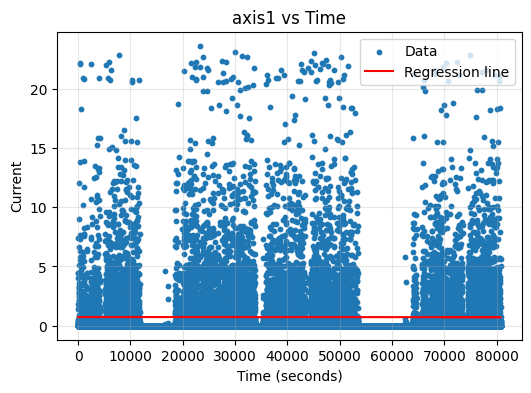

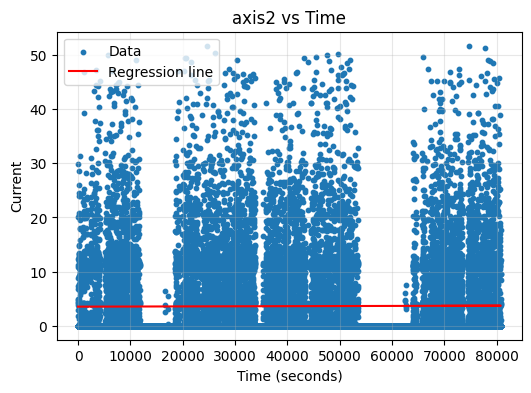

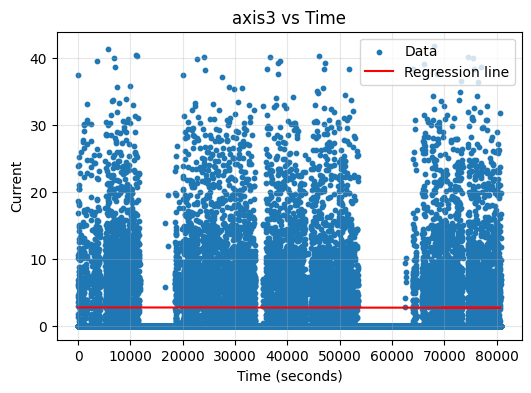

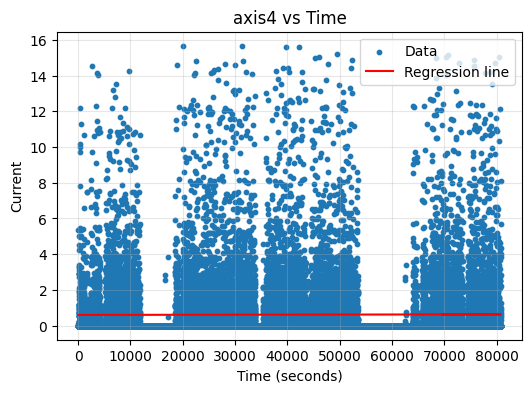

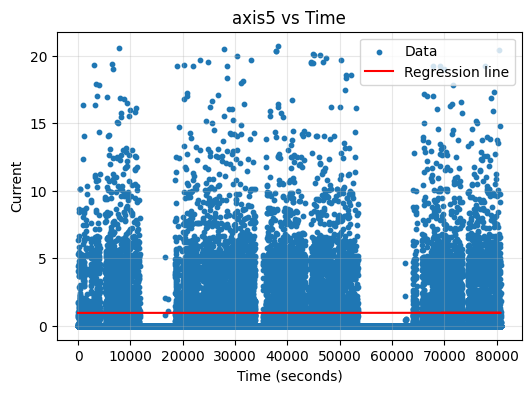

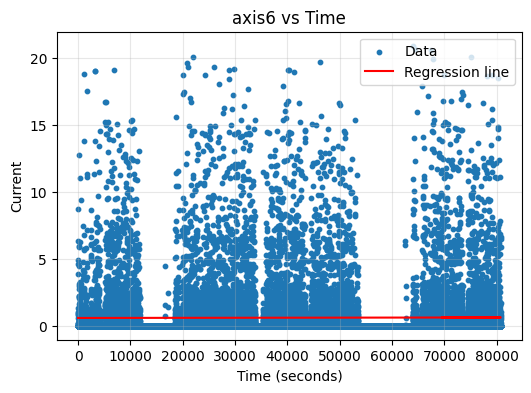

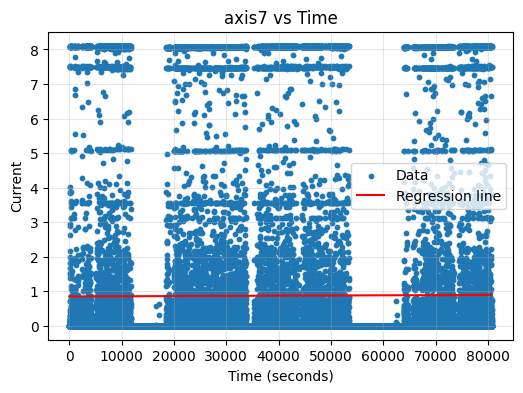

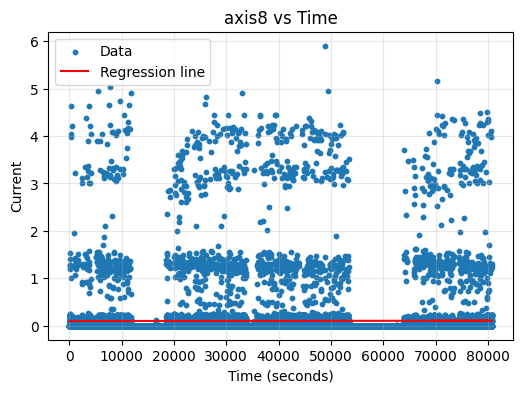

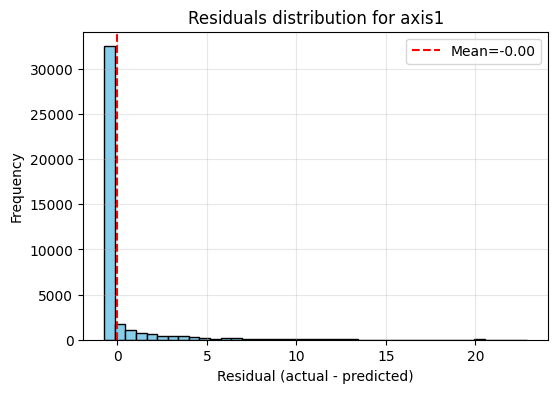

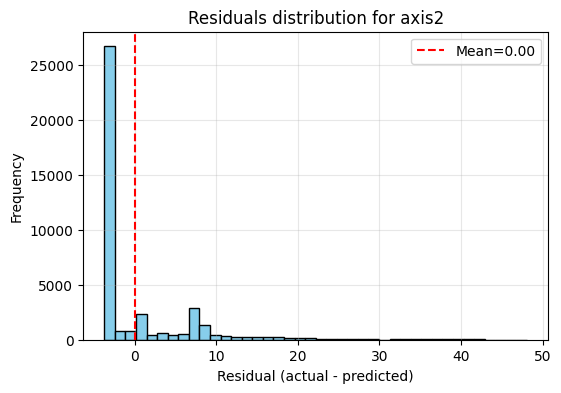

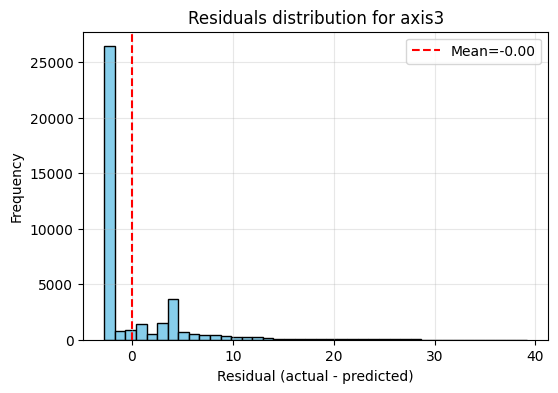

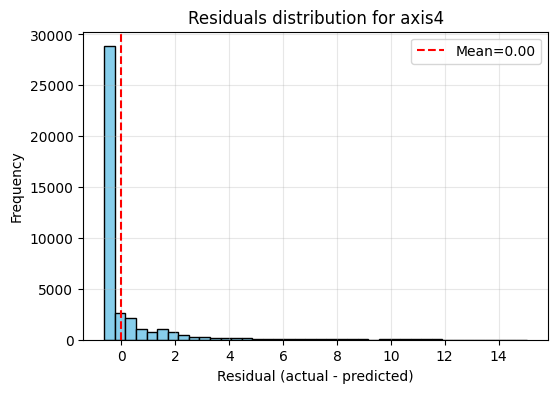

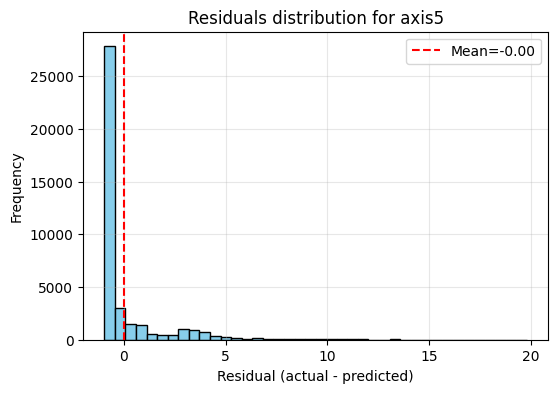

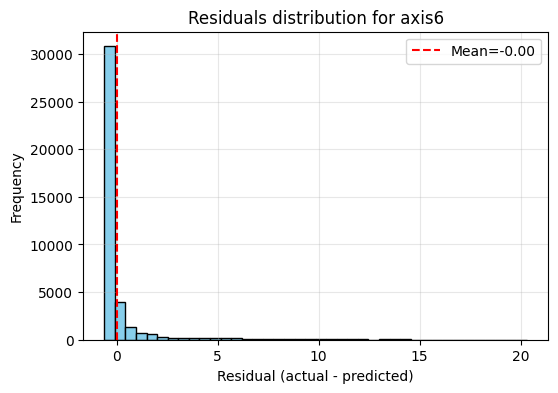

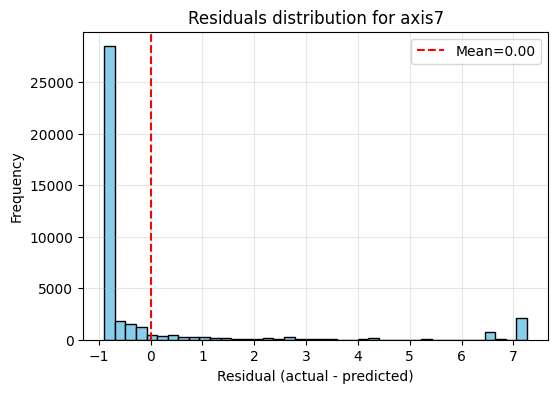

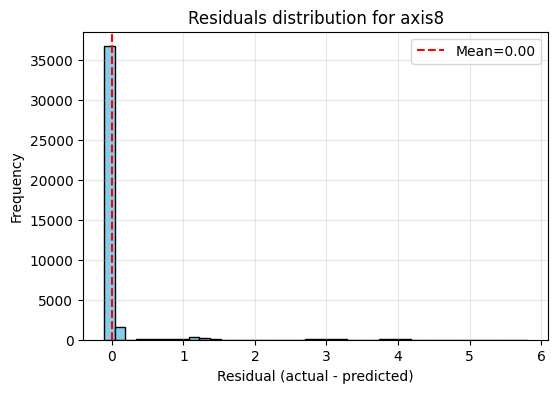

In [3]:
# --- Step 2: Visualization ---

# 1) Plot scatter + regression line for each axis
for axis in AXES:
    y = df_train[axis].values
    X = df_train[['time_numeric']].values
    y_pred = models[axis].predict(X)
    
    plt.figure(figsize=(6,4))
    plt.scatter(df_train['time_numeric'], y, label='Data', s=10)
    plt.plot(df_train['time_numeric'], y_pred, color='red', label='Regression line')
    plt.title(f'{axis} vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Current')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 2) Plot histograms of residuals
for axis in AXES:
    res = residuals_dict[axis]
    
    plt.figure(figsize=(6,4))
    plt.hist(res, bins=40, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(res), color='red', linestyle='--', label=f"Mean={np.mean(res):.2f}")
    plt.title(f'Residuals distribution for {axis}')
    plt.xlabel('Residual (actual - predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Discover thresholds (MinC, MaxC)

In [4]:
# --- Step 3: Threshold Discovery ---

def discover_thresholds(residuals_dict, method="percentile",
                        minc_q=97.5, maxc_q=99.5,
                        k_min=2.5, k_max=3.5):
    rows = []
    minc_by_axis = {}
    maxc_by_axis = {}
    
    for axis, res in residuals_dict.items():
        res = np.asarray(res)
        pos = res[res > 0]   # focus on positive residuals only
        if len(pos) == 0:
            pos = res  # fallback if all values <= 0

        if method == "percentile":
            MinC = float(np.percentile(pos, minc_q))
            MaxC = float(np.percentile(pos, maxc_q))
        elif method == "std":
            mu = float(np.mean(pos))
            sigma = float(np.std(pos, ddof=0))
            MinC = mu + k_min * sigma
            MaxC = mu + k_max * sigma
        else:
            raise ValueError("method must be 'percentile' or 'std'")
        
        minc_by_axis[axis] = MinC
        maxc_by_axis[axis] = MaxC
        rows.append({"axis": axis, "MinC": MinC, "MaxC": MaxC})
    
    return pd.DataFrame(rows), minc_by_axis, maxc_by_axis

# --- Calculate thresholds both ways ---
thr_table_pct, MinC_pct, MaxC_pct = discover_thresholds(
    residuals_dict, method="percentile", minc_q=95, maxc_q=98
)

thr_table_std, MinC_std, MaxC_std = discover_thresholds(
    residuals_dict, method="std", k_min=2.5, k_max=3.5
)

print("📊 Percentile-based thresholds:")
display(thr_table_pct)

print("📊 Std-based thresholds:")
display(thr_table_std)

# Save for later / README
thr_table_pct.to_csv(DATA_DIR / "thresholds_percentile.csv", index=False)
thr_table_std.to_csv(DATA_DIR / "thresholds_std.csv", index=False)


📊 Percentile-based thresholds:


,axis,MinC,MaxC
0,axis1,11.343826,15.557040
1,axis2,24.567595,33.815481
2,axis3,19.659364,24.923293
3,axis4,7.206002,10.611322
4,axis5,8.516996,11.642954
5,axis6,9.469247,12.932467
6,axis7,7.232741,7.244916
7,axis8,3.136179,3.918179


📊 Std-based thresholds:


,axis,MinC,MaxC
0,axis1,12.922450,16.784425
1,axis2,27.933964,35.763480
2,axis3,20.561974,26.383488
3,axis4,7.920240,10.342461
4,axis5,9.984031,12.809243
5,axis6,10.110378,13.305862
6,axis7,11.445049,14.359989
7,axis8,2.879637,3.839790


## Synthetic Data Generation

In [5]:
from synthetic_data import make_synthetic_test

# --- Step 4: Use external synthetic data generator ---
df_test, sample_interval_sec = make_synthetic_test(
    df_train, models, AXES,
    anomaly_blocks=5,
    block_min_sec=15, block_max_sec=25,
    residuals_dict=residuals_dict,
    force_above=True,   # ensure anomalies exceed MaxC
    MinC=MinC_pct, 
    MaxC=MaxC_pct
)

# Save for reproducibility
synthetic_path = DATA_DIR / "Synthetic_test.csv"
df_test.to_csv(synthetic_path, index=False)

print(f"✅ Synthetic test data saved to {synthetic_path}")
print(df_test.head())


✅ Synthetic test data saved to Data\Synthetic_test.csv
                              time  time_numeric     axis1     axis2      axis3     axis4     axis5     axis6  \
0 2022-10-18 10:45:00.519000+00:00         0.000  1.389368  3.497449   1.816929 -3.685892  5.250972 -3.365271   
1 2022-10-18 10:45:02.410000+00:00         1.891 -1.517998 -0.230891   1.959436 -1.891581  4.069671  1.457945   
2 2022-10-18 10:45:04.301000+00:00         3.782  2.353085  1.560868   4.080064 -2.076979  1.791396  0.673123   
3 2022-10-18 10:45:06.192000+00:00         5.673  2.764128  4.538042  -2.189341 -1.262888 -0.177773  1.842635   
4 2022-10-18 10:45:08.083000+00:00         7.564 -3.487774 -1.876997  11.438700  0.083660 -1.399045 -0.237926   

      axis7     axis8  
0  3.238792  0.549319  
1  4.393976  0.537043  
2 -2.353552  0.688603  
3  4.965829 -1.090496  
4  0.592390  0.611913  


## Streaming Detection (Alerts/Errors with T)

In [12]:
import math, uuid
from dataclasses import dataclass

# Use percentile thresholds
MinC, MaxC = MinC_pct, MaxC_pct  

# Time window
sample_interval_sec = float(np.nanmedian(df_train['time'].diff().dt.total_seconds()))
T_seconds = 2
rows_required = max(1, math.ceil(T_seconds / sample_interval_sec))
print(f"T = {T_seconds}s | {sample_interval_sec:.2f}s per row | rows_required={rows_required}")

@dataclass
class Event:
    event_id: str
    axis: str
    level: str   # ALERT / ERROR
    start_idx: int
    end_idx: int
    start_time: pd.Timestamp
    end_time: pd.Timestamp
    duration_sec: float
    mean_residual: float
    peak_residual: float

def detect_events_stream(df, axes, models, MinC, MaxC, rows_required):
    events = []
    residuals_test = {}
    X_test = df[['time_numeric']].values

    for axis in axes:
        y = df[axis].values
        yhat = models[axis].predict(X_test)
        r = y - yhat
        residuals_test[axis] = r

        alert_count = error_count = 0
        alert_start = error_start = None

        for i, ri in enumerate(r):
            # --- ERROR first
            if ri >= MaxC[axis]:
                if error_count == 0: error_start = i
                error_count += 1; alert_count = 0; alert_start = None
            elif ri >= MinC[axis]:
                if alert_count == 0: alert_start = i
                alert_count += 1; error_count = 0; error_start = None
            else:
                if error_count >= rows_required:
                    seg = r[error_start:i]
                    events.append(Event(str(uuid.uuid4())[:8], axis, "ERROR", error_start, i-1,
                        df.loc[error_start,'time'], df.loc[i-1,'time'],
                        error_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
                if alert_count >= rows_required:
                    seg = r[alert_start:i]
                    events.append(Event(str(uuid.uuid4())[:8], axis, "ALERT", alert_start, i-1,
                        df.loc[alert_start,'time'], df.loc[i-1,'time'],
                        alert_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
                alert_count = error_count = 0
                alert_start = error_start = None

        # finalize at stream end
        i = len(r)
        if error_count >= rows_required:
            seg = r[error_start:i]
            events.append(Event(str(uuid.uuid4())[:8], axis, "ERROR", error_start, i-1,
                df.loc[error_start,'time'], df.loc[i-1,'time'],
                error_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
        if alert_count >= rows_required:
            seg = r[alert_start:i]
            events.append(Event(str(uuid.uuid4())[:8], axis, "ALERT", alert_start, i-1,
                df.loc[alert_start,'time'], df.loc[i-1,'time'],
                alert_count*sample_interval_sec, float(np.nanmean(seg)), float(np.nanmax(seg))))
    return events, residuals_test

events, residuals_test = detect_events_stream(df_test, AXES, models, MinC, MaxC, rows_required)


events_df = pd.DataFrame([e.__dict__ for e in events])
events_df.to_csv(DATA_DIR / "events_log.csv", index=False)
print(f"✅ Saved {len(events_df)} events to Data/events_log.csv")
events_df.head()


T = 2s | 1.89s per row | rows_required=2
✅ Saved 5 events to Data/events_log.csv


,event_id,axis,level,start_idx,end_idx,start_time,end_time,duration_sec,mean_residual,peak_residual
0,1cc3a871,axis4,ERROR,6507,6516,2022-10-18 14:10:05.256000+00:00,2022-10-18 14:10:22.275000+00:00,18.910,14.815093,16.979558
1,eaec9e84,axis4,ERROR,18590,18602,2022-10-18 20:30:54.209000+00:00,2022-10-18 20:31:16.901000+00:00,24.583,14.564313,17.312361
2,166f4b1f,axis4,ERROR,28110,28112,2022-10-19 01:30:56.529000+00:00,2022-10-19 01:31:00.311000+00:00,5.673,16.257521,18.174535
3,1bc037aa,axis4,ERROR,29335,29344,2022-10-19 02:09:33.004000+00:00,2022-10-19 02:09:50.023000+00:00,18.910,16.577335,17.627983
4,eda7b0d6,axis6,ERROR,27769,27777,2022-10-19 01:20:11.698000+00:00,2022-10-19 01:20:26.826000+00:00,17.019,19.780669,22.387001


## Visualize Residuals with Event Overlays

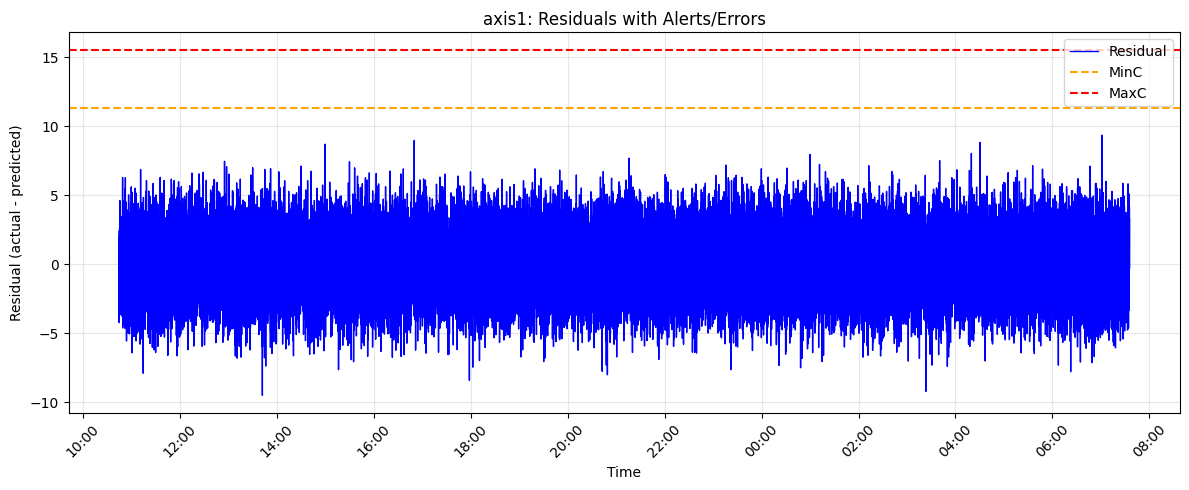

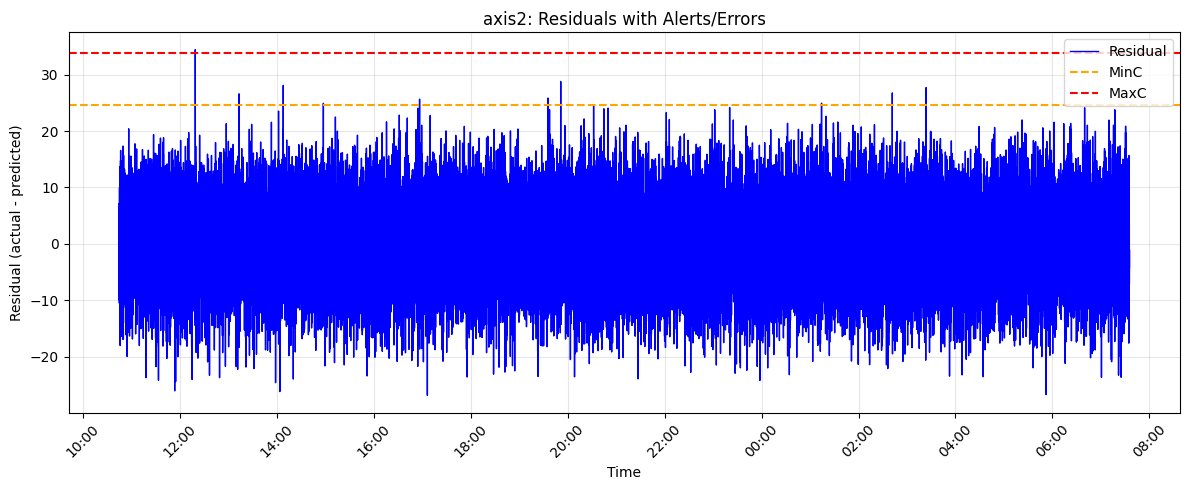

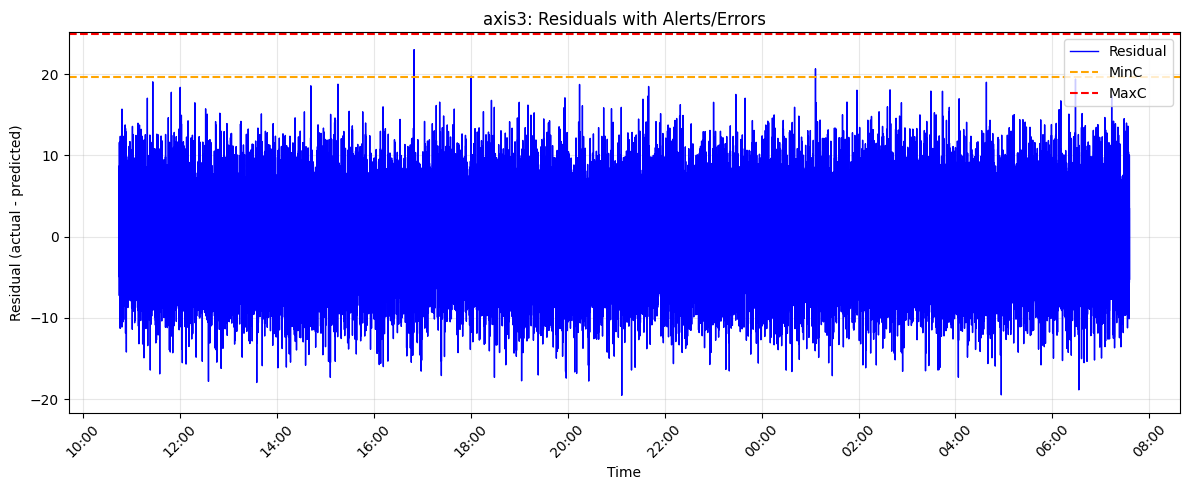

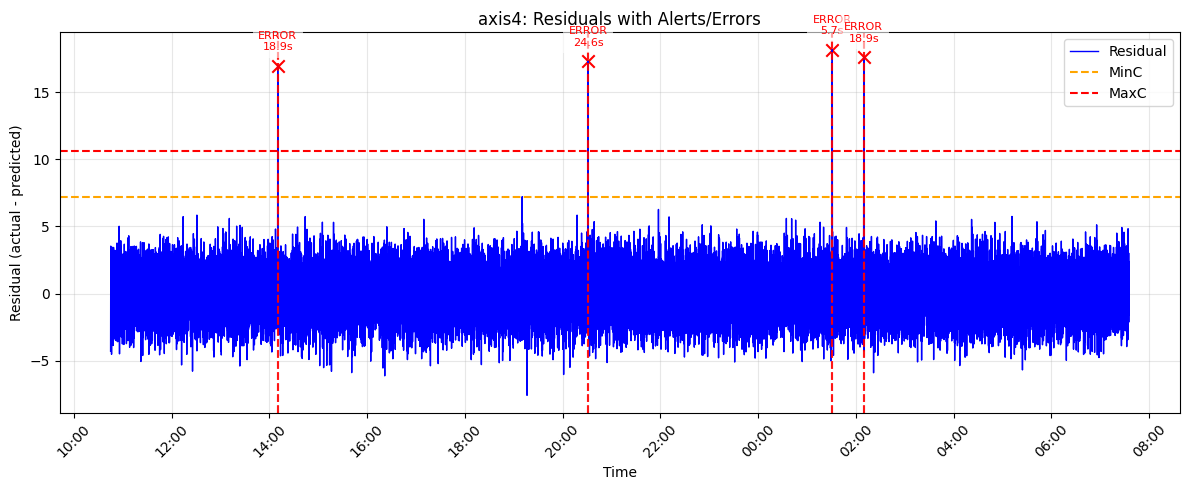

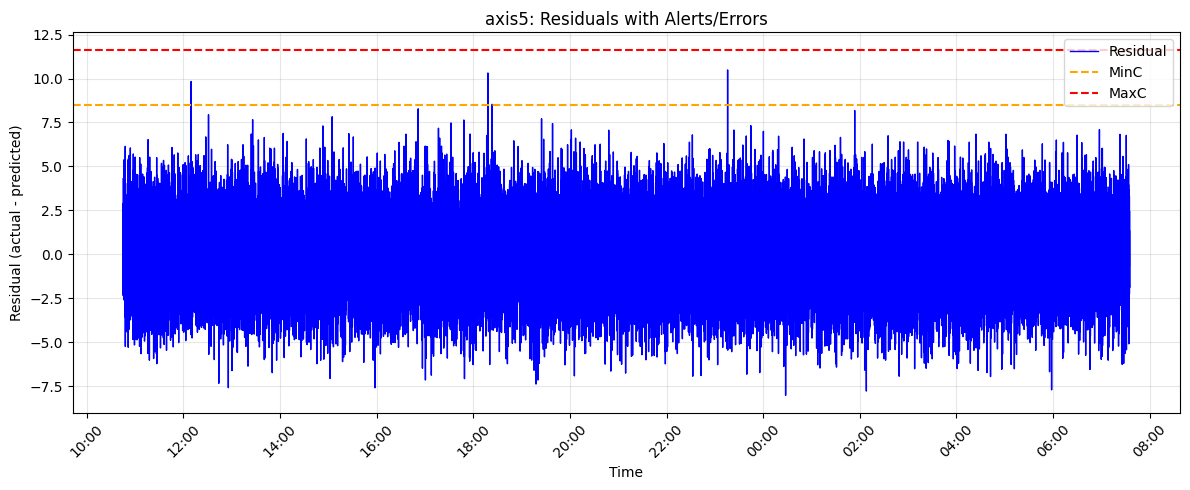

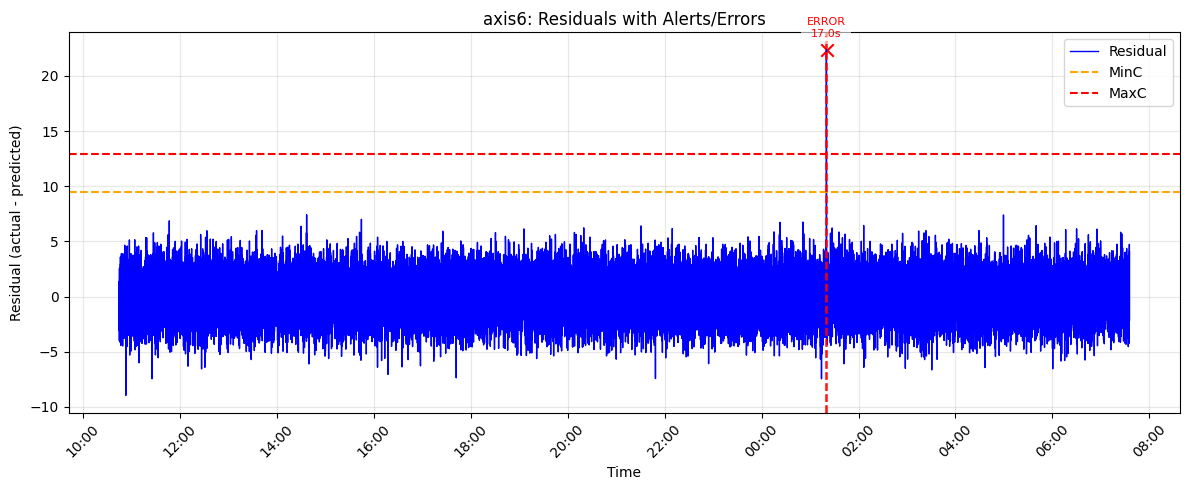

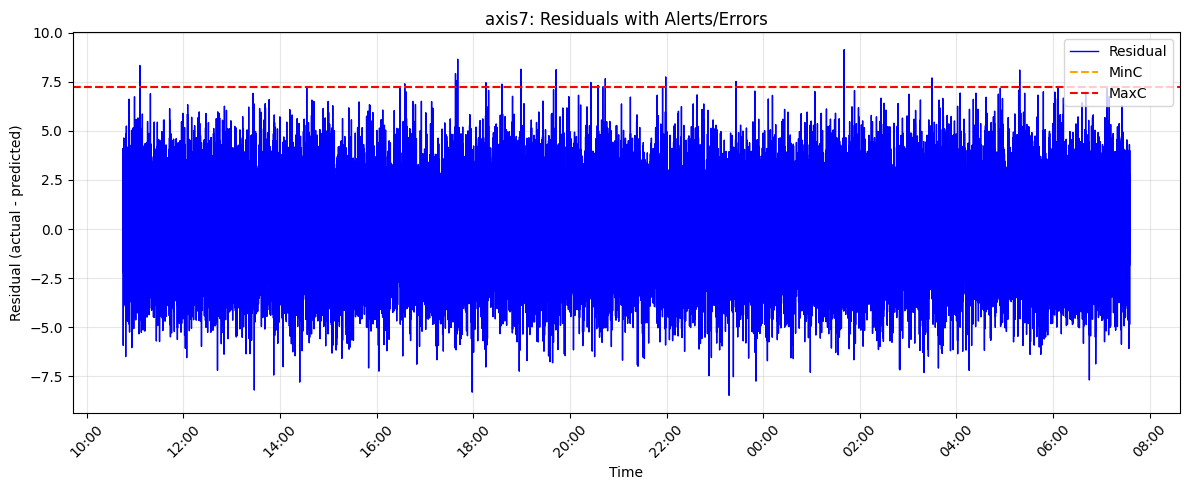

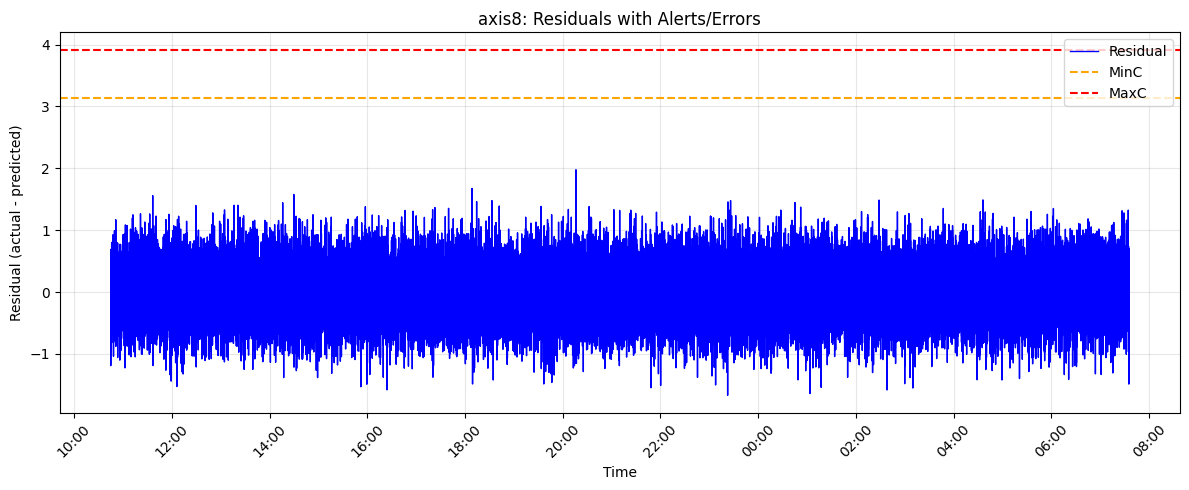

In [13]:
import matplotlib.dates as mdates

def plot_residuals_with_events(axis, df, residuals_test, MinC, MaxC, events):
    r = residuals_test[axis]
    t = df['time'].values

    plt.figure(figsize=(12,5))
    plt.plot(t, r, color="blue", linewidth=1, label="Residual")
    plt.axhline(MinC[axis], linestyle="--", color="orange", label="MinC")
    plt.axhline(MaxC[axis], linestyle="--", color="red", label="MaxC")

    for ev in events:
        if ev.axis != axis:
            continue

        # Vertical span for event
        plt.axvline(df.loc[ev.start_idx, 'time'], color="green" if ev.level=="ALERT" else "red",
                    linestyle="--", alpha=0.7)
        plt.axvline(df.loc[ev.end_idx, 'time'], color="green" if ev.level=="ALERT" else "red",
                    linestyle="--", alpha=0.7)

        # Mark peak point
        plt.scatter(df.loc[ev.end_idx,'time'], ev.peak_residual,
                    color="red" if ev.level=="ERROR" else "orange", marker="x", s=80)

        # Duration label in the middle of event
        mid_idx = ev.start_idx + (ev.end_idx - ev.start_idx)//2
        mid_time = df.loc[mid_idx, 'time']
        plt.text(mid_time, ev.peak_residual + 1,
                 f"{ev.level}\n{ev.duration_sec:.1f}s",
                 color="red" if ev.level=="ERROR" else "orange",
                 ha="center", va="bottom", fontsize=8,
                 bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    # Format time axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   # every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # show HH:MM
    plt.xticks(rotation=45)

    plt.title(f"{axis}: Residuals with Alerts/Errors")
    plt.xlabel("Time")
    plt.ylabel("Residual (actual - predicted)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Run visualization for all axes ---
for axis in AXES:
    plot_residuals_with_events(axis, df_test, residuals_test, MinC, MaxC, events)
